In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In the previous section, we only used one layer of neural network to classify images, achieving good classification accuracy. In this section, we use the king of image classification: convolutional neural networks (CNN).let's start!  
In convolutional neural networks, there are two most common operations: convolution and pooling. As shown below. We first use two functions to implement the above two operations respectively, so that you will have a clearer understanding of convolution and pooling.  
**Note**: The calculation formula of the data size after convolution is:  
$$
\left(n_h-k_h+1\right) \times\left(n_w-k_w+1\right)
$$

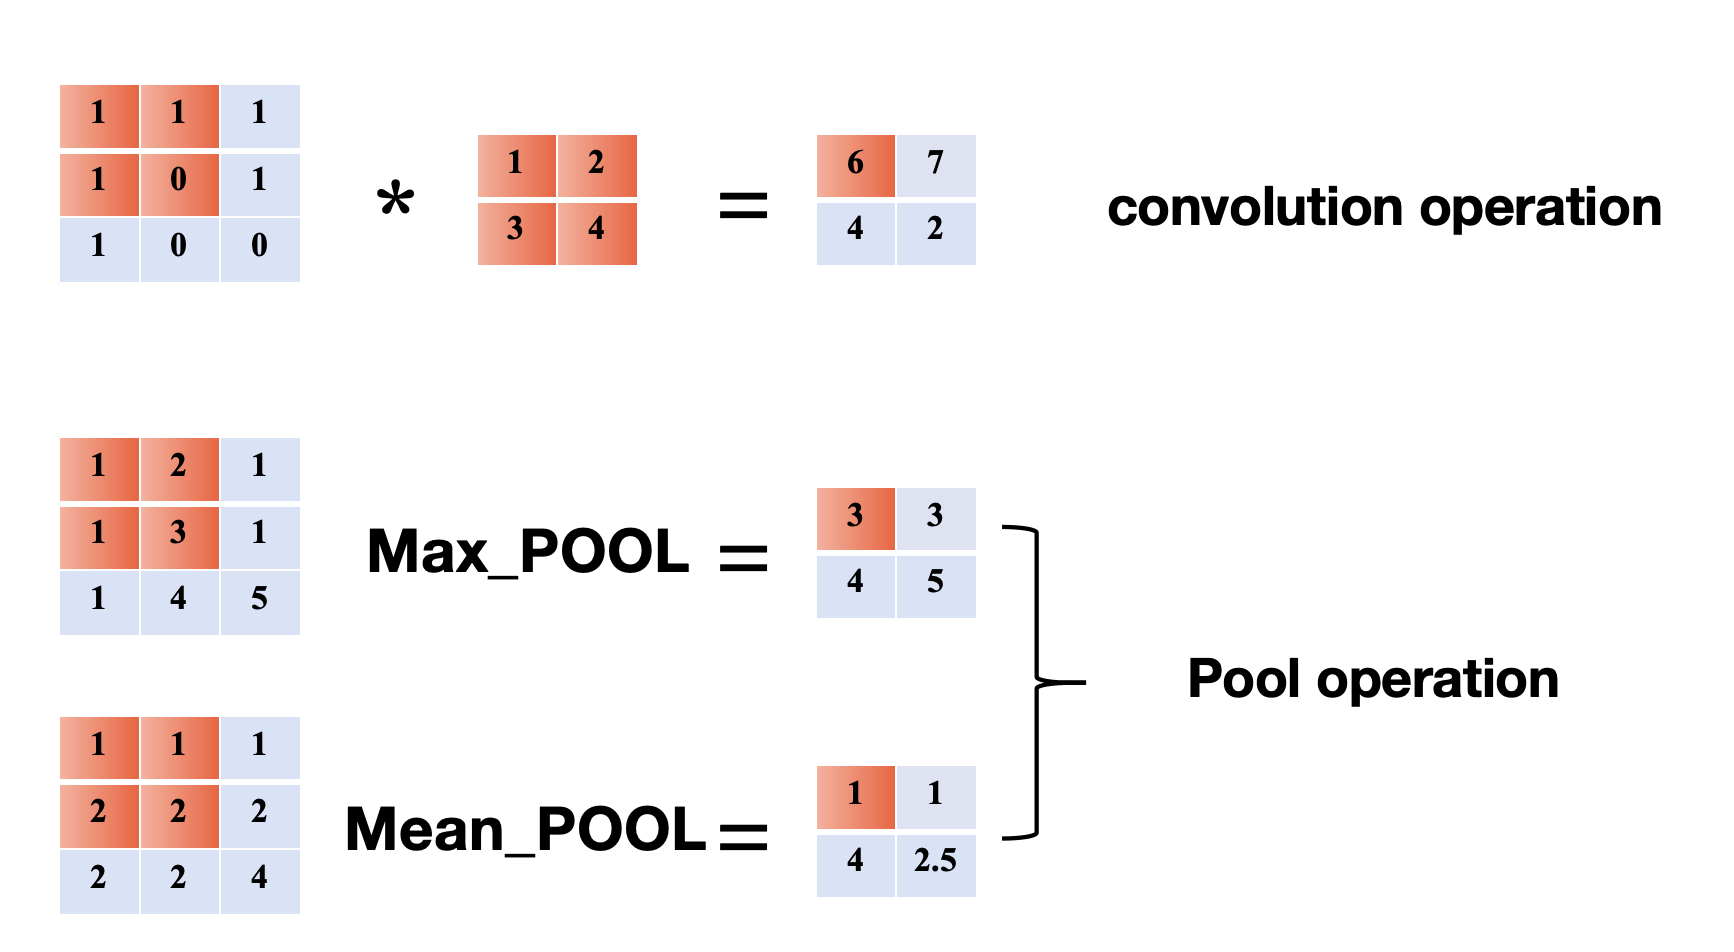

In [2]:
# convolution
def conv2d(x, kernel):
  h, w = kernel.shape
  y = torch.zeros((x.shape[0] - h + 1, x.shape[1] - w + 1))
  for i in range(y.shape[0]):
    for j in range(y.shape[1]):
      y[i, j] = (x[i:i+h, j:j+w] * kernel).sum()
  return y

In [3]:
# test
x = torch.randn(3, 3)
kernel = torch.randn(2, 2)
conv2d(x, kernel).shape

torch.Size([2, 2])

In [4]:
# pool
def pool2d(x, pool_size, pool='max'):
  # pool_size is a tuple
  h, w = pool_size
  y = torch.zeros((x.shape[0] - h + 1, x.shape[1] - w + 1))
  for i in range(y.shape[0]):
    for j in range(y.shape[1]):
      if pool == 'max':
        y[i, j] = x[i:i+h, j:j+w].max()
      elif pool == 'mean':
        y[i, j] = x[i:i+h, j:j+w].mean()
  return y

In [ ]:
x = torch.randn(3, 3)
x

tensor([[ 1.7334, -0.6425, -0.5527],
        [ 0.0383,  0.5714, -0.3130],
        [ 1.9915, -0.7327,  0.7843]])

In [ ]:
y1 = pool2d(x, (2, 2))
y2 = pool2d(x, (2, 2), pool='mean')
y1, y2

(tensor([[1.7334, 0.5714],
         [1.9915, 0.7843]]),
 tensor([[ 0.4251, -0.2342],
         [ 0.4671,  0.0775]]))

From the above code we can find that the pooling operation does not have any dot product operation!  
Through these two functions, we can know how the convolution and pooling operations are implemented in the code. Of course, this is just the simplest operation!  
So next we will specifically use convolutional neural networks to implement image classification! We use the classic CNN architecture: LeNet network to implement image classification! As shown below:  
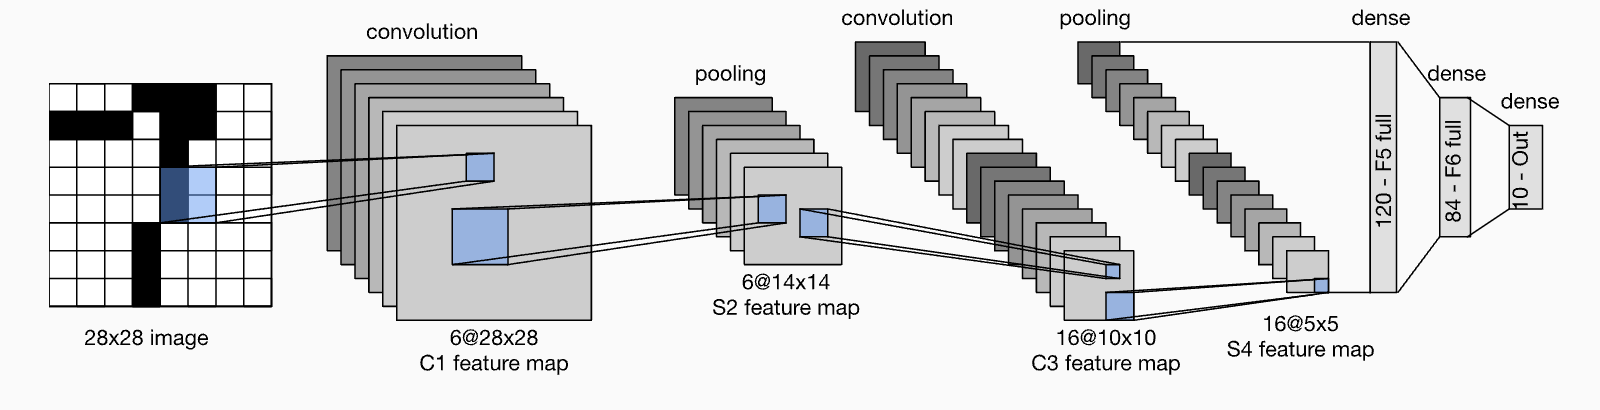

We can determine the stride and padding size according to the following formula:  
$$
\left\lfloor\left(n_h-k_h+p_h+s_h\right) / s_h\right\rfloor \times\left\lfloor\left(n_w-k_w+p_w+s_w\right) / s_w\right\rfloor
$$

In [18]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=3, padding=1)
    self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
    self.flatten = nn.Flatten()
    self.dense1 = nn.Linear(16 * 5 * 5, 120)
    self.sigmoid1 = nn.Sigmoid()
    self.dense2 = nn.Linear(120, 84)
    self.sigmoid2 = nn.Sigmoid()
    self.dense3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.flatten(self.pool2(self.conv2(self.pool1(self.conv1(x)))))
    x = self.dense3(self.sigmoid2(self.dense2(self.sigmoid1(self.dense1(x)))))
    return x

In [ ]:
# test
x = torch.randn(1, 1, 28, 28)
net = LeNet()
net(x).shape

torch.Size([1, 10])

In [6]:
# Download MNIST dataset
train_data = torchvision.datasets.MNIST('./data', train=True, download=True,
                                        transform=transforms.ToTensor())
test_data = torchvision.datasets.MNIST('./data', train=False, download=True,
                                       transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 63187660.33it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 74636903.16it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25642524.38it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14090627.79it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



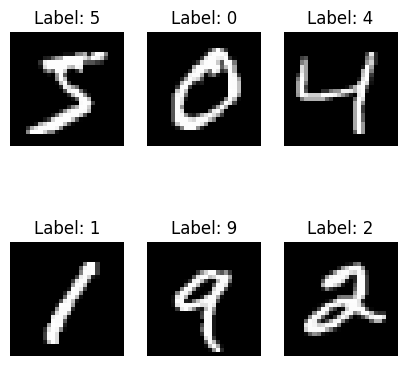

In [7]:
_, axes = plt.subplots(2, 3, figsize=(5, 5))
num_imgs = 6
for i in range(num_imgs):
  img, label = train_data[i]
  ax = axes[i//3, i%3]
  ax.imshow(img.squeeze(), cmap='gray')
  ax.set_title(f'Label: {label}')
  ax.axis('off')

In [8]:
batch_size = 256
lr = 0.01
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [9]:
# loss, optimizer
net = LeNet()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [15]:
num_epochs = 10
loss_value = []
acc_value = []

In [10]:
def validation(model, data_loader):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for img, label in data_loader:
      y = model(img)
      _, predicted = torch.max(y, dim=1)
      correct += (predicted == label).sum()
      total += label.size(0)
  return correct / total

In [16]:
for epoch in range(num_epochs):
  batch_loss = []
  for i, (img, label) in enumerate(train_loader):
    l = loss(net(img), label)
    batch_loss.append(l.item())
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    batch_loss.append(l.item())
    if (i+1) % 100 == 0:
      print(f'Step:{i+1}/{len(train_loader)}, Epoch:{epoch+1}/{num_epochs}, Loss:{l.item():.4f}')
  avg_loss = sum(batch_loss) / len(batch_loss)
  loss_value.append(avg_loss)
  accuracy = validation(net, test_loader)
  acc_value.append(accuracy)
  print(f'Step:{i+1}/{len(train_loader)}, Epoch:{epoch+1}/{num_epochs}, Accuracy:{accuracy:.2f}')



Step:100/235, Epoch:1/10, Loss:0.3382
Step:200/235, Epoch:1/10, Loss:0.2141
Step:235/235, Epoch:1/10, Accuracy:0.94
Step:100/235, Epoch:2/10, Loss:0.1936
Step:200/235, Epoch:2/10, Loss:0.2088
Step:235/235, Epoch:2/10, Accuracy:0.96
Step:100/235, Epoch:3/10, Loss:0.1402
Step:200/235, Epoch:3/10, Loss:0.1269
Step:235/235, Epoch:3/10, Accuracy:0.96
Step:100/235, Epoch:4/10, Loss:0.1817
Step:200/235, Epoch:4/10, Loss:0.1087
Step:235/235, Epoch:4/10, Accuracy:0.96
Step:100/235, Epoch:5/10, Loss:0.0670
Step:200/235, Epoch:5/10, Loss:0.1334
Step:235/235, Epoch:5/10, Accuracy:0.97
Step:100/235, Epoch:6/10, Loss:0.0496
Step:200/235, Epoch:6/10, Loss:0.0768
Step:235/235, Epoch:6/10, Accuracy:0.97
Step:100/235, Epoch:7/10, Loss:0.0483
Step:200/235, Epoch:7/10, Loss:0.0580
Step:235/235, Epoch:7/10, Accuracy:0.97
Step:100/235, Epoch:8/10, Loss:0.0743
Step:200/235, Epoch:8/10, Loss:0.0605
Step:235/235, Epoch:8/10, Accuracy:0.97
Step:100/235, Epoch:9/10, Loss:0.0749
Step:200/235, Epoch:9/10, Loss:0.0

This is CNN. In just a few steps, the accuracy can reach such a high level!

In [41]:
def plot_loss_acc(loss, acc, figsize, num_epochs, xlabel1='Epoch', ylabel1='Loss', ylabel2='Accuracy', color1='red', color2='blue'):
  fig, ax1 = plt.subplots(figsize=figsize)
  ax1.set_xlabel(xlabel1)
  ax1.set_ylabel(ylabel1, color=color1)
  ax1.plot(range(1, num_epochs+1, 1), loss, color=color1)
  # Configure the style of tick marks on the axis
  ax1.tick_params(axis='y', labelcolor=color1)
  ax2 = ax1.twinx()
  ax2.set_ylabel(ylabel2, color=color2)
  ax2.plot(acc, color=color2)
  ax2.tick_params(axis='y', labelcolor=color2)

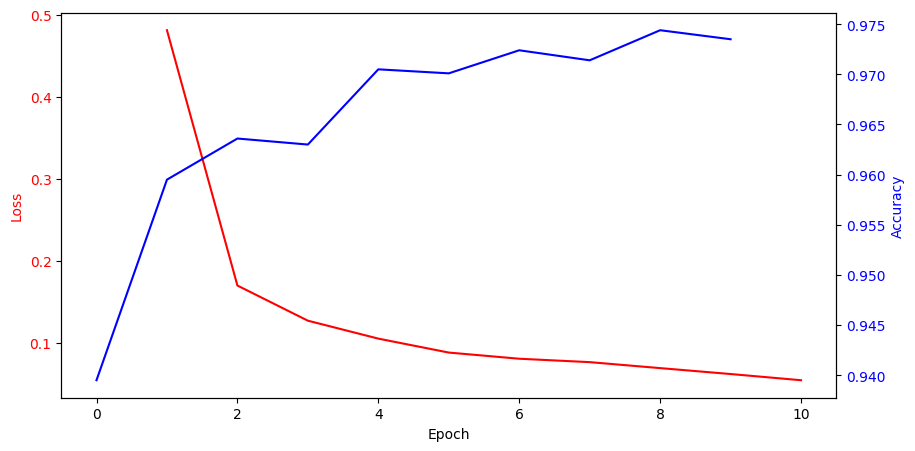

In [42]:
plot_loss_acc(loss_value, acc_value, figsize=(10, 5), num_epochs=10)